# Conversion rate DC
# Task
Your project is to:
1. Perform Exploratory Data Analysis and produce 2-3 plots that show either important
features or interesting patterns in the data. It is up to you what you want to highlight.
2. Build a model to predict conversion rate and critically evaluate it, explaining your choice
of model and performance metric.
3. Come up with recommendations for the product team and the marketing team to
improve conversion rate.

## Step1: Explorative  Data analysis

In [9]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Import function for the prediction model
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Upload data
df = pd.read_csv('conversion_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
df.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [6]:
# Check how many different countris we have
len(df['country'].unique())

4

In [8]:
len(df['source'].unique())

3

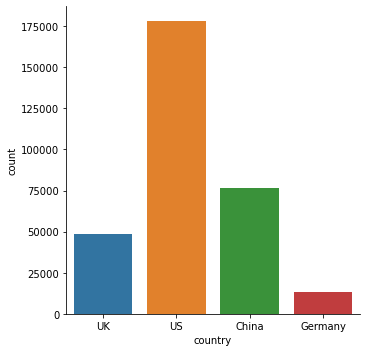

In [10]:
# Visualizations
sns.catplot(x='country', kind='count', data=df);

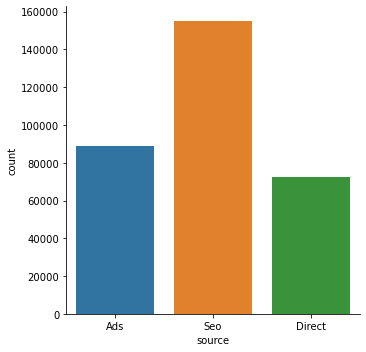

In [11]:
sns.catplot(x='source', kind = 'count', data=df)

In [12]:
len(df['new_user'].unique())

2

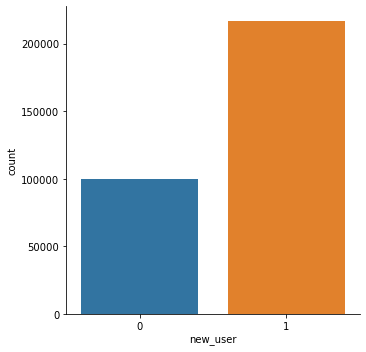

In [13]:
sns.catplot(x='new_user', kind='count', data=df)

In [ ]:
sns.catplot(x='new_user', kind='count', data=df)

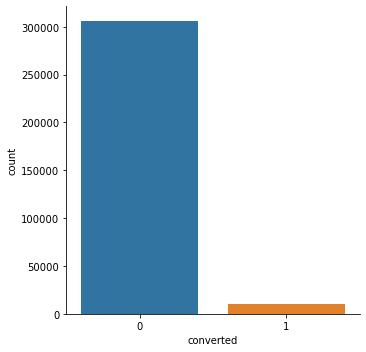

In [19]:
sns.catplot(x='converted', kind='count', data=df);

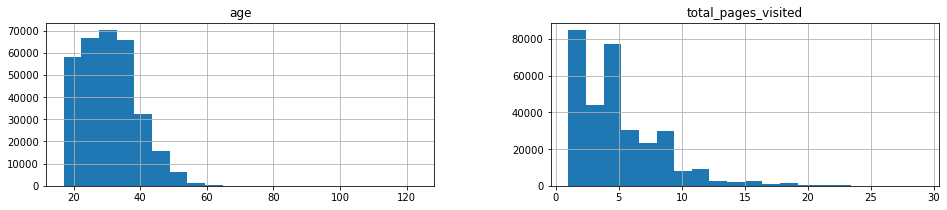

In [14]:
# Check some numerical distributions
features = ['age', 'total_pages_visited']
df.hist(column=features, bins=20, layout=(1,2), figsize=(16,3));

In [20]:
# Take a closer look at the user that converted. To do this we need to subset the df
converted_df = df.loc[df['converted'] == 1]

In [25]:
num_of_conv = len(converted_df)
num_of_conv

10200

In [26]:
total_users = len(df)
total_users

316200

In [27]:
conv_rate = num_of_conv/total_users
conv_rate

0.03225806451612903

In [29]:
total_conv_flag = df.groupby('converted')['new_user'].count()
total_conv_flag

converted
0    306000
1     10200
Name: new_user, dtype: int64

In [31]:
# Def a function to calculate the conversion rate
def conversion_rate(df):
    total_conv_flag = df.groupby('converted')['new_user'].count()
    num_of_nonconv = total_conv_flag[0]
    num_of_conv = total_conv_flag[1]
    total_users = len(df)
    
    conv_rate = num_of_conv/total_users
    return conv_rate

In [32]:
conversion_rate(df)

0.03225806451612903

## Some visualization for converter users

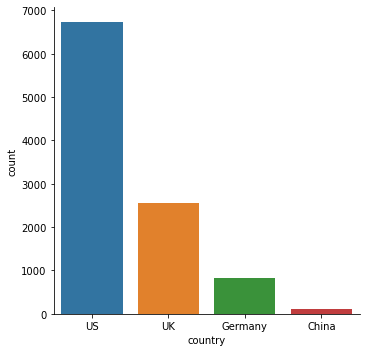

In [33]:
sns.catplot(x='country', kind='count', data=converted_df);

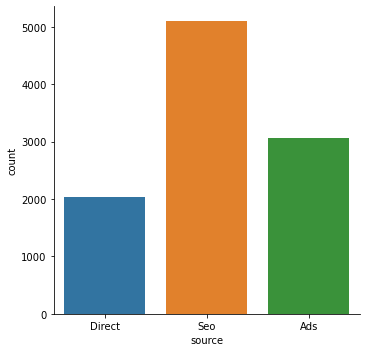

In [34]:
sns.catplot(x='source', kind = 'count', data=converted_df)

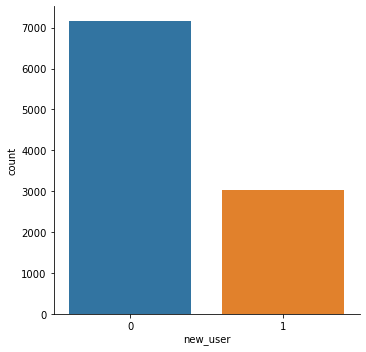

In [35]:
sns.catplot(x='new_user', kind='count', data=converted_df)

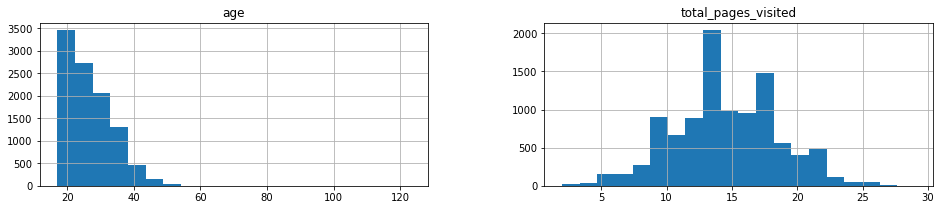

In [36]:
# Check some numerical distributions
features = ['age', 'total_pages_visited']
converted_df.hist(column=features, bins=20, layout=(1,2), figsize=(16,3));

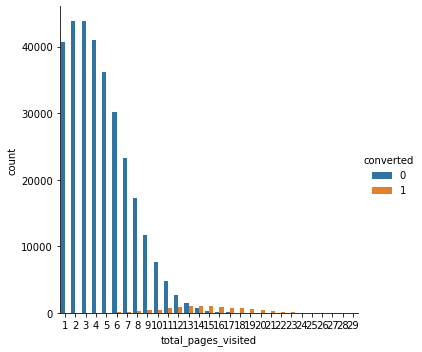

In [37]:
sns.catplot(x='total_pages_visited', kind = 'count', hue='converted', data=df);

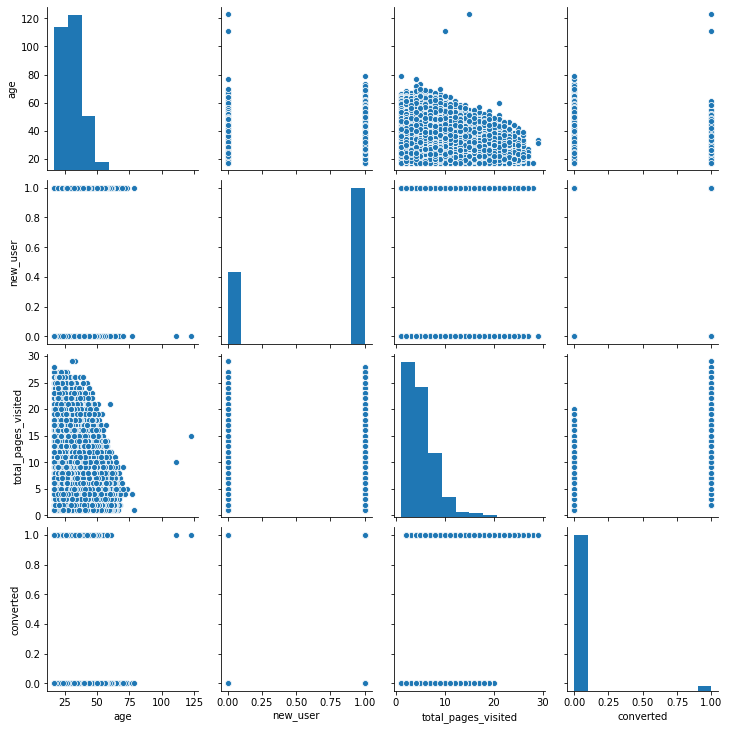

In [15]:
# Look for correlations...
sns.pairplot(df)

## Categorical variables
Before developping the prediction model, we need to take care of the two categorical variables: Country and source. Otherwise they cannot be used into the model.

In [41]:
# Convert categorical variables
encode_categories = {"country":     {"US": 1, "UK": 2, "Germany": 3, "China": 4},
                     "source": {"Ads": 1, "Seo": 2, "Direct": 3}}
df_transf = df.replace(encode_categories)

In [42]:
df_transf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   country              316200 non-null  int64
 1   age                  316200 non-null  int64
 2   new_user             316200 non-null  int64
 3   source               316200 non-null  int64
 4   total_pages_visited  316200 non-null  int64
 5   converted            316200 non-null  int64
dtypes: int64(6)
memory usage: 14.5 MB


In [43]:
df_transf.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,1,1,0
1,1,23,1,2,5,0
2,1,28,1,2,4,0
3,4,39,1,2,5,0
4,1,30,1,2,6,0


## Classification Model
This is a binary classification problem and we can use different prediction models. The simplest one could be a Logistic regression model or a SVM or finally a Random Forest.

We can now focus on building and training the model that estimates the probability that an user will convert or not.

The class `RunningModel` coded below takes care of 
* splitting the dataset in train and test according to the fraction declared with the parameter `test_fraction`;
* separating features from the target;
* scaling the features properly, for an easier optimization;
* estimating the performance of the model with the metrics accuracy and f_score,
* and ploting the confusion matrix;

The class has also a method that tell us the relaive importance of each feature in predicting the renewal probability (method `get_feature_importance`). 
And a method that return the computed probability score per agreement, as requested by the Sale team. \
The class can accept any model developed in the scikit-learn package.

We chose to train a random forest model. The main reason of this choice is because most of the features are categorical, and some of them have an arbitrary enumeration.


In [66]:
class RunningModel():
    
    def __init__(self, transformed_df, model, target_field='converted', ref_fields=None, test_fraction=0.3):
        """
        param transformed_df: dataframe with features, target, and reference columns
        param model: the model to fit
        param target_field: name of the column with the target
        param ref_fields: list of reference column names used to identify each case
        param test_fraction: indicates fraction of data used for testing, when spliting between train and test  
        """
        self.transformed_df = transformed_df.copy()
        self.model = model
        self.target_field = target_field
        self.ref_fields = ref_fields if (type(ref_fields) == list) or (ref_fields is None) else [ref_fields]
        self.test_fraction = test_fraction
        self.Features = self.get_features()
        self.Target = self.get_target()
    
    def get_target(self):
        return self.transformed_df[self.target_field].values
    
    def get_features(self):
        not_feature_fields = self.ref_fields + [self.target_field]
        return self.transformed_df.drop(not_feature_fields, axis=1)
    
    def running_model(self):
        """Split the dataset in train and test, and fit the model on the train"""
        X_train_unscaled, X_test_unscaled, self.y_train, self.y_test = \
            train_test_split(self.Features, self.Target, 
                             test_size=self.test_fraction, random_state=1)
        self.scaler = StandardScaler().fit(X_train_unscaled)
        self.X_train = self.scaler.transform(X_train_unscaled)
        self.X_test = self.scaler.transform(X_test_unscaled)
        self.model.fit(self.X_train, self.y_train)

    def model_estimator(self):
        """Calculate accurancy, f_score, precision, recall and plot the confusion matrix for the train and test datasets"""
        for X, y, label in [[self.X_train, self.y_train, 'Train'], 
                            [self.X_test, self.y_test, 'Test']]:
            y_pred = self.model.predict(X)
            cnf_matrix = metrics.confusion_matrix(y, y_pred).astype(float)
            accurancy = float(cnf_matrix[0][0] + cnf_matrix[1][1])/cnf_matrix.sum()
            print('Accuracy %s = %.3f' % (label, accurancy))
            f_score = self.f_score(y, y_pred)
            print('F1_score %s = %.3f\n' % (label, f_score))
            # Calculate Precision
            # Precision = true_pos/(true_pos + False_pos)
            # precision = float(cnf_matrix[0][0])/cnf_matrix[0].sum()
            precision = float(cnf_matrix[0][0])/(cnf_matrix[0][0] + cnf_matrix[1][0])
            print('Precision %s = %.3f\n' % (label, precision))
            # Calculate Recall
            # Recall = true_pos/(true_pos + False_neg)
            #recall = float(cnf_matrix[0][0])/cnf_matrix[1].sum()
            recall = float(cnf_matrix[0][0])/(cnf_matrix[0][0] + cnf_matrix[0][1])
            print('Recall %s = %.3f\n' % (label, recall))
            cnf_matrix[0] /= cnf_matrix[0].sum()
            cnf_matrix[1] /= cnf_matrix[1].sum()
            self.plot_confusion_matrix(cnf_matrix, title='{} dataset'.format(label))
    
    def f_score(self, y_true, y_pred):
        pos_label = 0 if float(self.Target.sum())/self.Target.size>0.5 else 1
        return metrics.f1_score(y_true, y_pred, pos_label=pos_label)
    
    def plot_confusion_matrix(self, cm, 
                              #classes = ['terminated', 'renewed'],
                              classes = ['converted', 'not converter'],
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.xticks([0, 1], classes)
        plt.yticks([-0.5, 0, 1, 1.5], [''] + classes + [''])

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], '.2f'),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    def get_feature_importance(self):
        """Return a dataframe with a coefficient expressing the importace of each feature in the model"""
        if self.model.__class__.__name__ == 'RandomForestClassifier':
            coeff = self.model.feature_importances_
        else:
            coeff = self.model.coef_[0]
        df = pd.DataFrame({'Feature': self.Features.columns.values,
                           'coeff': coeff})
        return df.reindex(df['coeff'].abs().sort_values(ascending=False).index)

Accuracy Train = 0.951
F1_score Train = 0.557

Precision Train = 0.998

Recall Train = 0.951

Accuracy Test = 0.949
F1_score Test = 0.537

Precision Test = 0.997

Recall Test = 0.950



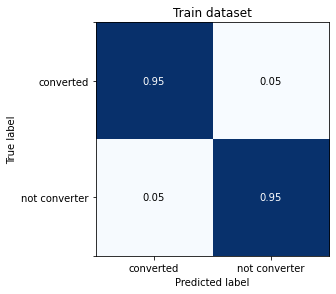

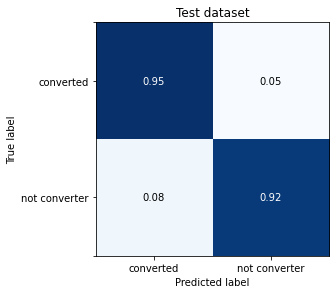

In [71]:
# Run the Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_features=5, criterion='entropy', 
                                  min_samples_split=64,
                                  min_samples_leaf=16,
                                  bootstrap = True,
                                  class_weight='balanced_subsample'
                                 )
ml = RunningModel(transformed_df=df_transf, #.drop(['parent'], axis=1), 
                  model=rf_model, 
                  target_field='converted', 
                  #ef_fields=['agreement_number', 'asset_sub_end_date'],
                  ref_fields=[],
                  test_fraction=0.2)
ml.running_model()
ml.model_estimator()

## Feature importance

In [48]:
ml.get_feature_importance()

,Feature,coeff
4,total_pages_visited,0.850284
1,age,0.056111
0,country,0.042094
2,new_user,0.035197
3,source,0.016314


Accuracy Train = 0.985
F1_score Train = 0.748

Precision Train = 0.989

Recall Train = 0.996

Accuracy Test = 0.986
F1_score Test = 0.760

Precision Test = 0.990

Recall Test = 0.996



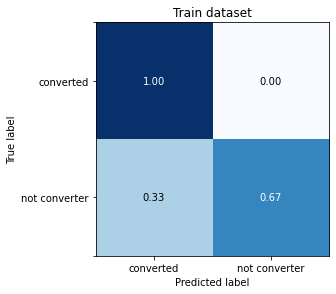

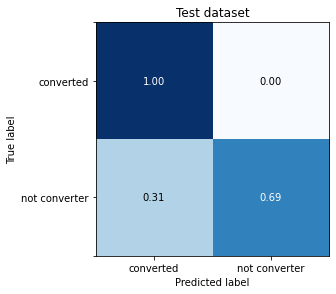

In [67]:
# Run the logistic regression
clf_model = LogisticRegression(random_state=0)

ml = RunningModel(transformed_df=df_transf, #.drop(['parent'], axis=1), 
                  model=clf_model, 
                  target_field='converted', 
                  #ef_fields=['agreement_number', 'asset_sub_end_date'],
                  ref_fields=[],
                  test_fraction=0.2)
ml.running_model()
ml.model_estimator()

In [64]:
ml.get_feature_importance()

,Feature,coeff
4,total_pages_visited,2.535080
2,new_user,-0.814337
1,age,-0.600461
0,country,-0.598059
3,source,-0.056901
